# I- Data Understanding:

In [ ]:
# importing files from drive

!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# import dataset from drive
downloaded = drive.CreateFile({'id':"183l9PRF3JK_SKxgGFTF6J_OxZSk4-BZ1"})
downloaded.GetContentFile('dataset.pickle')
# import text_preprocessed from drive
downloaded = drive.CreateFile({'id':"1PvQL6Cre83ixVf6huTPLux9z8YSIoTUL"})
downloaded.GetContentFile('text_preprocessed')
# import tokenizer from drive
downloaded = drive.CreateFile({'id':"1iELfJ0MR53gUY6TB4WJg0ivjBw3wavhq"})
downloaded.GetContentFile('tokenizer')
# import tokenized_data from drive
downloaded = drive.CreateFile({'id':"1Zh2ybJtE5lJsYurMa6UN_J74nt3K5wmW"})
downloaded.GetContentFile('tokenized_data')
# import shuffled_data from drive
downloaded = drive.CreateFile({'id':"1SbwVrbPfqPo8d404jgAqSSLQmyetjzaG"})
downloaded.GetContentFile('shuffled_data') 

In [ ]:
# Importing Libraries

!pip install bert-for-tf2
import pandas as pd
import pickle
import random
import gzip
import gensim 
import logging
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow import keras
import bert
import math
import re as re

In [ ]:
# Reading dataset

data = pd.read_pickle("dataset.pickle")
data.head()

,crunchbase_ID,home_text,aboutus_text,overview_text,whatwedo_text,company_text,whoweare_text,AI
0,1916,Skip to main content Products GPU accelerated ...,NaN,NaN,NaN,NaN,NaN,1
1,1917,Our AIs Research Company Careers Get in Touch ...,NaN,NaN,NaN,Our AIs Research Company Careers Get in Touch ...,NaN,1
2,1918,Toggle navigation Product Projects Company His...,NaN,NaN,NaN,NaN,NaN,1
3,1919,Brainpeek Solutions Create a seamless online u...,Brainpeek Solutions Create a seamless online u...,NaN,NaN,NaN,NaN,1
4,1920,The Tool Our Languages Services Extract Produc...,The Tool Our Languages Services Extract Produc...,NaN,NaN,NaN,NaN,1


In [ ]:
# Display the shape of data
data.shape

(4894, 8)

In [ ]:
# Display the column names
data.columns

Index(['crunchbase_ID', 'home_text', 'aboutus_text', 'overview_text',
       'whatwedo_text', 'company_text', 'whoweare_text', 'AI'],
      dtype='object')

In [ ]:
# Display the type of data
data.dtypes

crunchbase_ID    object
home_text        object
aboutus_text     object
overview_text    object
whatwedo_text    object
company_text     object
whoweare_text    object
AI                int64
dtype: object

In [ ]:
# Display the number of missing values for each column
data.isna().sum()

crunchbase_ID       0
home_text           0
aboutus_text     2682
overview_text    4828
whatwedo_text    4844
company_text     4417
whoweare_text    4811
AI                  0
dtype: int64

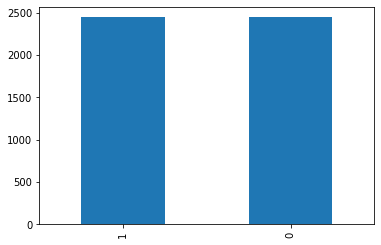

In [ ]:
# Display the distribution of data
data['AI'].value_counts().plot.bar()

# II- Data Preparation:

In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # Removing stop words
    sentence =  [word.lower() for word in sentence.split() if word not in stopwords.words('english')]
    # lemmatize data
    stemmer = WordNetLemmatizer()
    sentence = [stemmer.lemmatize(word) for word in sentence] 
    return ' '.join(sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Concatenate all text data expect the id of the company and the label column (AI)
data['text']=''
for i in data.columns[1:-1]:
  data['text']+=data[i].fillna("", inplace = False).astype('str')

In [ ]:
# preprocess the text data takes more then 5 minutes
L = []
sentences = list(data['text'])
for sen in sentences:
    L.append(preprocess_text(sen))

# save the result
open_file = open("text_preprocessed", "wb")
pickle.dump(L, open_file)
open_file.close()

In [ ]:
# import text_preprocessed
open_file = open("text_preprocessed", "rb")
text_preprocessed = pickle.load(open_file)
open_file.close()

In [ ]:
print(text_preprocessed[1])
print(data['AI'][1])

our ai research company career get touch our ai research company career get touch scroll ai everyone what that dmetrics founded leading expert ai natural language processing we built ai platform empowers business professional create deploy ai extract insight any text get result without writing code no code click an ai platform business expert actually use built you you granular target exact need one size fit nimble get going minute month adaptive need evolve ai trusted industry leader about company advancing ai nlp research view publication we growing looking top talent view career welcome founded code code built trusted research career dmetrics north th st brooklyn united state info dmetrics com hour our ai research company career contact privacy policy term condition dmetrics inc brooklyn united state info dmetrics com hour our ai research company career contact privacy policy term condition dmetrics inc com hour our ai research company career contact privacy policy term condition dm

In [ ]:
# Not to execute it takes more then 5 minutes

BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

# save the result
open_file = open("tokenizer", "wb")
pickle.dump(tokenizer, open_file)
open_file.close()

In [ ]:
# import tokenizer file
open_file = open("tokenizer", "rb")
tokenizer = pickle.load(open_file)
open_file.close()

In [ ]:
# Not to execute it takes more then 5 minutes
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

tokenized_data = [tokenize_reviews(d) for d in data['text']]

# save the result
open_file = open("tokenized_data", "wb")
pickle.dump(tokenized_data, open_file)
open_file.close()

In [ ]:
# import tokenized_data
open_file = open("tokenized_data", "rb")
tokenized_data = pickle.load(open_file)
open_file.close()

In [ ]:
# Build an X y list and shuffle the data
data = [[x,data['AI'][i]] for i, x in enumerate(tokenized_data)]
random.shuffle(data)
shuffled_data = [(x[0], x[1]) for x in data]

# save the result
open_file = open("shuffled_data", "wb")
pickle.dump(shuffled_data, open_file)
open_file.close() 

In [ ]:
# import shuffled_data
open_file = open("shuffled_data", "rb")
shuffled_data = pickle.load(open_file)
open_file.close()

# III- Modeling:

In [ ]:
# convert the sorted dataset into a TensorFlow 2.0-compliant input dataset shape.
processed_dataset = tf.data.Dataset.from_generator(lambda: shuffled_data, output_types=(tf.int32, tf.int32))

#  pad the dataset for each batch
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

# We divide the dataset into test and training sets
TOTAL_BATCHES = math.ceil(len(shuffled_data) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [ ]:
# Creating the model

class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [ ]:
# Defining hyper parameters
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 5

In [ ]:
# We create an object of the TEXT_MODEL class and pass the hyper paramters values 
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [ ]:
# Complie the model
text_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
# Training takes more than 5 minutes
text_model.fit(train_data, epochs=NB_EPOCHS)

Epoch 1/5
138/138 [==============================] - 989s 7s/step - loss: 0.2409 - accuracy: 0.8974
Epoch 2/5
138/138 [==============================] - 996s 7s/step - loss: 0.0101 - accuracy: 0.9961
Epoch 3/5
138/138 [==============================] - 993s 7s/step - loss: 0.0014 - accuracy: 1.0000
Epoch 4/5
138/138 [==============================] - 993s 7s/step - loss: 4.2759e-04 - accuracy: 1.0000
Epoch 5/5
138/138 [==============================] - 977s 7s/step - loss: 1.7041e-04 - accuracy: 1.0000


# IV- Evaluation:

In [ ]:
# Evaluate the model on test data
results = text_model.evaluate(test_data)
print(results)

15/15 [==============================] - 28s 2s/step - loss: 0.0148 - accuracy: 0.9937
[0.014763474464416504, 0.9937499761581421]


In [ ]:
# saving model
text_model.save('model',save_format='tf')

INFO:tensorflow:Assets written to: model.zip/assets


In [ ]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 1s (280 kB/s)
Selecting previously unselected package rar.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!zip -r "model.zip" "/content/model"

  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 22%)
  adding: content/model/variables/variables.index (deflated 66%)
  adding: content/model/saved_model.pb (deflated 89%)
